In [3]:
import numpy as np;
import matplotlib as mp;
import matplotlib.pyplot as plt;
import pandas as pd;
import math;
import scipy.special;
from sklearn.neighbors import KernelDensity;
from sklearn.model_selection import GridSearchCV;

# Empirical CDF and PDF

## Empirical CDF

The empirical CDF at a given $x$ can be simply obtained by taking the fraction of data points falling below $x$:
\begin{equation}
\widehat{F}(x) = \frac{1}{n} \left| \{x_i \mid x_i < x \} \right|. \nonumber
\end{equation}

Let's generate a random sample distributed according to the Normal distribution and compare the empirical and the true CDF, which can be written as 
\begin{equation}
F(x) = \frac{1}{2}\left[1+{\rm erf}\left(\frac{x - \mu}{\sqrt{2}\sigma}\right)\right]. \nonumber
\end{equation}

In [35]:
mu = 2.0;
sigma = 5.0;
num_data_points = 5000;

In [36]:
norm_data = np.random.normal(mu,sigma,num_data_points)

To construct the empirical CDF, we can e.g., make first a histogram, and then use numpy.cumsum() that returns a list with the elements equal to the summed values up to the given index.

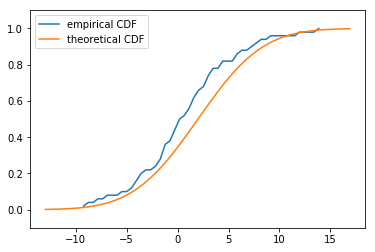

In [20]:
counts,bins = np.histogram(norm_data,bins=50,density=False); # it is important that here we simply count 
                                                             # the number of data points in the bins, and do 
                                                             # not normalise.
counts = counts.astype(float)/len(norm_data); # here we divide the counts by n, the number of data points.               
cdf = np.cumsum(counts);   # and finally, this is where add up the results up to a given bin.

plt.clf();
plt.plot(bins[:-1],cdf, label = 'empirical CDF');

x_vec = np.arange(mu - 3.0*sigma,mu + 3.0*sigma,0.1);
y_vec = [0.5*(1.0+scipy.special.erf((x-mu)/math.sqrt(2.0)/sigma)) for x in x_vec];
plt.plot(x_vec,y_vec, label = 'theoretical CDF');
plt.ylim(-0.1,1.1);
plt.legend(loc='upper left',fontsize = 10);
plt.show();

We can also avoid binning the data, and provide an empirical CDF "as detailed as possible". We have to simply sort the data point, and the empirical CDF is a step-wise increasing function, where the increase in the height is $1/n$ at a step.

We can e.g., define a function that returns the sorted data points and the step-wise increasing CDF.

In [21]:
def CDF(data_list):
    num_points = len(data_list);
    sorted_data = np.sort(data_list);
    cdf = np.arange(1, num_points + 1) / num_points;
    return sorted_data,cdf;

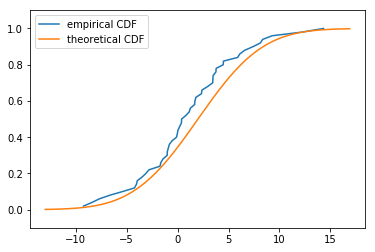

In [22]:
cdf_x,cdf_y = CDF(norm_data);
plt.clf();
plt.plot(cdf_x,cdf_y,label = 'empirical CDF');
plt.plot(x_vec,y_vec, label = 'theoretical CDF');
plt.ylim(-0.1,1.1);
plt.legend(loc='upper left',fontsize = 10);
plt.show();

We can see that the most of the discrepancy between the empirical and the true CDF in the previous figure was due to binning. 

Let's also prepare a **confidence band** based on the DKW inequality, which states that for a chosen $\alpha$, a confidence band of the form 
\begin{equation}
 P\left(\widehat{F}(x)-\epsilon < F(x) <\widehat{F}(x)+\epsilon\right)\geq 1-\alpha \nonumber
\end{equation}
can be given where 
\begin{equation}
 \epsilon= \sqrt{\frac{1}{2n}\ln\left(\frac{2}{\alpha}\right)}. \nonumber
\end{equation}

We define a function that prepares both the empirical CDF and the confidence band for a chosen $\alpha$.

In [23]:
def CDF_confidence_band(data_list,alpha):
    num_points = len(data_list);
    sorted_data = np.sort(data_list);
    cdf = np.arange(1, num_points + 1) / num_points;
    eps = math.sqrt(0.5*math.log(2.0/alpha)/num_points);
    L_x,U_x = [y + eps for y in cdf],[y - eps for y in cdf];
    return {'x':sorted_data,'CDF':cdf,'L':L_x,'U':U_x};

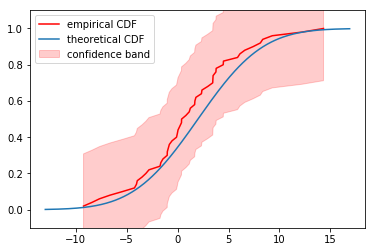

In [26]:
conf_band = CDF_confidence_band(norm_data,alpha=0.0005);

plt.clf();
plt.fill_between(conf_band['x'],conf_band['U'],conf_band['L'],alpha = 0.2,color = 'red',label = 'confidence band');
plt.plot(conf_band['x'],conf_band['CDF'], color = 'r',label = 'empirical CDF');
plt.plot(x_vec,y_vec, label = 'theoretical CDF');
plt.ylim(-0.1,1.1);
plt.legend(loc='upper left',fontsize = 10);
plt.show();

It is instructive to see how does the confidence band depend on the parameters.
 - ** try changing $\alpha$ **,
 - ** try changing the number of data points**.

## Empirical PDF

Probably the most simple estimator of the PDF $\rho(x)$ is the histogram estimator with equal bin width $h$, where 
\begin{equation}
\widehat{\rho}_n(x)= \sum_{j=1}^m \frac{\widehat{p}_j}{h} I(x \in B_j)=
\sum_{j=1}^m \frac{\nu_j}{nh} I(x \in B_j). \nonumber
\end{equation}

Choosing the optimal bin width is a non-trivial problem. It turns out, that the mean integrated squared error, also called as risk in a cross validation approach can be estimated (apart from an additive constant independent of $h$) using
\begin{equation}
\widehat{J}(h)=\int \widehat{\rho}_n^2(x)dx -\frac{2}{n}\sum_{i=1}^n \widehat{\rho}_{(i)}(x= x_i), \nonumber
\end{equation}
where $\widehat{\rho}_{(i)}$ is the histogram estimator obtained by removing data point $x_i$ from the sample. The value of $\widehat{J}(h)$ can also be given in even more simple terms as
\begin{equation}
\widehat{J}(h)=\frac{2}{h(n-1)} -\frac{n+1}{h(n-1)}\sum_{j=1}^m \widehat{p}_j^2=
\frac{2}{h(n-1)} -\frac{n+1}{h(n-1)n^2}\sum_{j=1}^m \nu_j^2. \nonumber
\end{equation} 

Let's first prepare the histogram of the normal data set where we can adjust the bin width to any chosen value. 

We are going to use numpy's histogram function, and specify equal sized bins starting from the lowest sample element, ending at the highest sample value, and having a prescribed bin width.

In [37]:
bin_width = 0.8;
n_hist,n_bins = np.histogram(norm_data,
                             bins=np.arange(min(norm_data)-bin_width*0.5,max(norm_data)+bin_width*0.5,bin_width),
                             normed = True);

Let's plot the histogram and the true PDF together.

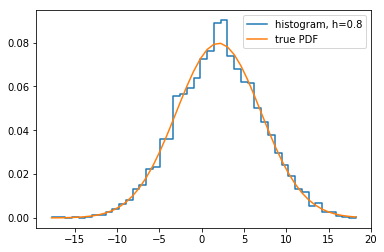

In [38]:
plt.clf();
plt.step(n_bins[:-1],n_hist, where = 'post', label = 'histogram, h='+str(bin_width));
pdf_theor = [math.exp(-(x-mu)**2/2.0/sigma**2)/math.sqrt(2.0*np.pi)/sigma for x in n_bins[:-1]];
plt.plot(n_bins[:-1],pdf_theor,label= 'true PDF');
plt.legend(loc = 'upper right',fontsize = 10)
plt.show();

** Try out smaller and larger bin width values and see how the histogram is changing **

Let us now examine the estimate for the risk in order to be able to choose the optimal bin width.

First, we define a function calculating $\widehat{J}$. 

In [39]:
def J_estimate(data,bin_width):
    counts,bins = np.histogram(data,
                             bins=np.arange(min(data)-bin_width*0.5,max(data)+bin_width*0.5,bin_width),
                             normed = False);
    n_d = len(data);
    p_list = [c/n_d for c in counts];
    return 2.0/bin_width/(n_d-1.0)-(n_d + 1.0)/bin_width/(n_d-1.0)*sum([p*p for p in p_list]);

Next, we calculate it for a range of $h$  bin width values, and plot the results.

In [40]:
h_list = np.arange(0.01,5,0.05);
J_list = [J_estimate(norm_data,h) for h in h_list];

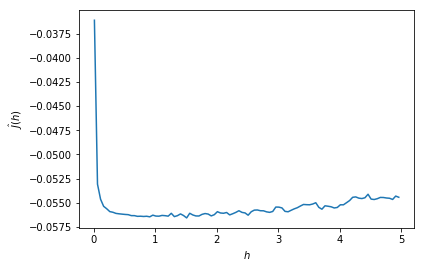

In [42]:
plt.clf();
plt.plot(h_list,J_list);
plt.xlabel('$h$')
plt.ylabel('$\widehat{J}(h)$')
plt.show();

According to the plot, the optimal bin width is somewhere around 1.

## PDF for real data

Let's try out the framework shown above for real data. We are going to use the methylation data from the previous lesson.

In [43]:
file_name = "ASC_cg_export.tsv";
pd.read_csv(file_name, sep = '\t', low_memory=False)

,patient_id,cg00510787,cg03169527,cg23256971,cg08585897
0,0,0.076000,0.031020,0.681708,0.136734
1,1,0.056540,0.041740,0.309939,0.833063
2,2,0.035931,0.027603,0.336823,0.779083
3,3,0.068871,0.029245,0.637028,0.220080
4,4,0.055457,0.031569,0.648768,0.158911
5,5,0.061143,0.023658,0.642102,0.225108
6,6,0.036393,0.021858,0.590512,0.343928
7,7,0.047970,0.030301,0.208783,0.904000
8,8,0.082713,0.032664,0.636139,0.175850
9,9,0.369641,0.218340,0.648431,0.180848


The code above just showed the data, let's now read it into a pandas data frame.

In [44]:
data_frame = pd.read_csv(file_name,sep = '\t',low_memory=False);

First let's determine the optimal bin width using $\widehat{J}(h)$. Important: **the data frame contains nan values in some places**, which can ruin the analysis, so we have to get rid of them before actually doing any calculations. A simple solution is to convert the columns to numpy arrays and remove the nans from those.

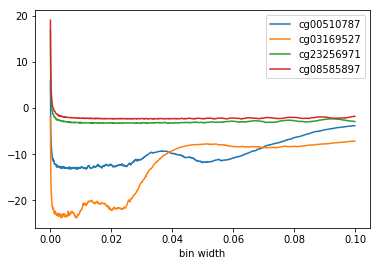

In [45]:
cg_h_range = np.arange(0.0001,0.1,0.0001);  # this is the range for the h binwidth values

plt.clf();
for cg_ind in range(1,5):
    data_with_possible_nans = np.array(data_frame.iloc[:,cg_ind]); # at this phase we can have possibly nans  
    data_without_nans = data_with_possible_nans[np.logical_not(np.isnan(data_with_possible_nans))]; # here we get rid
                                                                                                    # of them
    
    J_cg_list = [J_estimate(data_without_nans,b) for b in cg_h_range];   # we simply apply the J estimator
    plt.plot(cg_h_range,J_cg_list,label = data_frame.columns[cg_ind]);   # and plot the results
#plt.xlim(0,0.02);
plt.xlabel('bin width');
plt.legend(loc = 'upper right',fontsize = 10);
plt.show();

It seems that $h=0.008$ is a reasonably good choice for the bin width.

Let's now prepare the histogram estimator for the PDFs and plot them together. 

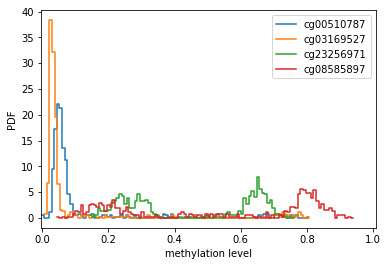

In [46]:
bin_width = 0.008;
plt.clf();
for cg_ind in range(1,5):
    data_with_possible_nans = np.array(data_frame.iloc[:,cg_ind]);
    data_without_nans = data_with_possible_nans[np.logical_not(np.isnan(data_with_possible_nans))];
    cg_hist,cg_bins = np.histogram(data_without_nans,
                                   bins = np.arange(min(data_without_nans)-bin_width*0.5,
                                                    max(data_without_nans)+bin_width*0.5,bin_width),
                                   normed = True);
    plt.step(cg_bins[:-1],cg_hist,where = 'post',label = data_frame.columns[cg_ind]);
plt.xlim(-bin_width*0.5,1.0+bin_width);
plt.legend(loc = 'upper right',fontsize = 10);
plt.xlabel('methylation level');
plt.ylabel('PDF');
plt.show();

## Kernel density estimation

The kernel density estimation of the PDF is based on some smooth kernel function $K(x)$ with 0 mean and positive variance, and a bandwidth $h$. At a given point $x$, the estimate for $\rho(x)$ is written as
\begin{equation}
\widehat{\rho}_n(x)=\frac{1}{n}\sum_{i=1}^n\frac{1}{h}K\left(\frac{x-x_i}{h}\right). \nonumber
\end{equation}
The advantages of this approach compared to the histogram estimator are that
 - the obtained empirical PDF is much smoother,
 - and it also has faster convergence to the true PDF as a function of $n$ if we choose the optimal bandwidth.

Let's try it out!

First we define the estimator and the kernel function, which, for simplicity is going to be a Gaussian kernel.

In [47]:
def Kernel_estimate(Kernel_func,data,x,bandwidth):
    return sum([Kernel_func((x - x_i)/bandwidth) for x_i in data])/bandwidth/len(data);

In [48]:
def K_f(x):
    return math.exp(-0.5*x*x)/math.sqrt(2.0*np.pi);

We can apply this e.g., to the normal data we have generated previously.

In [57]:
h_bw = 15.2;                      # the bandwidth 
x_list = np.arange(-15,20,0.1);  # the x values where we evaluate the estimator;
y_list = [Kernel_estimate(K_f,norm_data,x,h_bw) for x in x_list];

And now we can plot the result together with the true PDF.

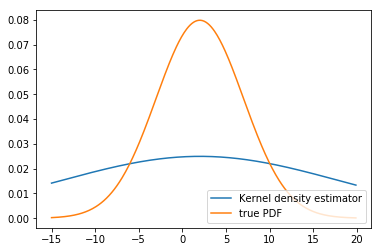

In [58]:
plt.clf();
plt.plot(x_list,y_list,label = 'Kernel density estimator');
pdf_th = [math.exp(-(x-mu)**2/2.0/sigma**2)/math.sqrt(2.0*np.pi)/sigma for x in x_list];
plt.plot(x_list,pdf_th,label= 'true PDF');
plt.legend(loc = 'lower right',fontsize = 10);
plt.show();

** Try out a few bandwidth values and see what happens. **

How to determine the optimal value for the bandwidth?

Luckily, kernel density estimation is already implemented in **sklearn**, and we can use the functions defined there.

First we need to 'reshape' our data to make it compatible with the package.

In [59]:
norm_data_reshaped = norm_data[:,np.newaxis];

Now let's determine the optimal bandwidth.

In [60]:
params = {'bandwidth': np.linspace(1.0, 2.0, 10)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
grid.fit(norm_data_reshaped);
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 1.0


Based on that, we can prepare the kernel density estimator.

In [61]:
norm_kde = KernelDensity(kernel='gaussian', bandwidth=1.56).fit(norm_data_reshaped);

Let's evaluate and plot it.

In [62]:
x_reshaped = np.linspace(-15, 20, 1000)[:, np.newaxis];
log_dens = norm_kde.score_samples(x_reshaped);

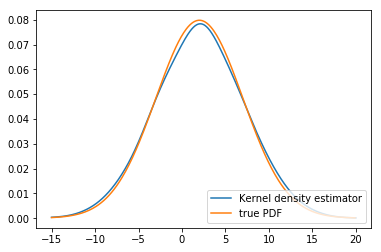

In [63]:
plt.clf();
plt.plot(x_reshaped,np.exp(log_dens),label = 'Kernel density estimator');
pdf_th = [math.exp(-(x-mu)**2/2.0/sigma**2)/math.sqrt(2.0*np.pi)/sigma for x in x_list];
plt.plot(x_list,pdf_th,label= 'true PDF');
plt.legend(loc = 'lower right',fontsize = 10);
plt.show();

Finally, let's prepare the kernel density estimator for the PDF of one of the methylation positions.

First, we need to get rid of the nans and put the data into a shape that can be processed further by the sklearn functions.

In [64]:
meth_data_with_nans = np.array(data_frame.iloc[:,3]);
meth_data = meth_data_with_nans[np.logical_not(np.isnan(meth_data_with_nans))];
meth_data = meth_data[:,np.newaxis];

Then we determine the optimal bandwidth.

In [65]:
params = {'bandwidth': np.linspace(0.001, 0.02, 200)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
grid.fit(meth_data);
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 0.017422110552763822


We can now prepare the KDE, and evaluate the resulting empirical PDF in a range of x values.

In [66]:
kde_methyl = KernelDensity(kernel='gaussian', bandwidth=0.0174).fit(meth_data);
meth_x_list = np.linspace(-0.01, 1.01, 1000)[:, np.newaxis];
meth_log_dens = kde_methyl.score_samples(meth_x_list);

Finally, we can prepare a plot, together with the former histogram estimator.

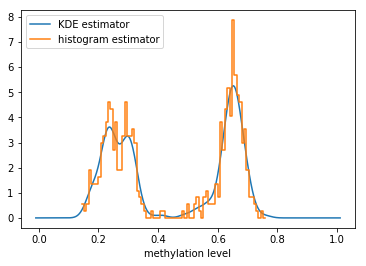

In [67]:
cg_hist,cg_bins = np.histogram(meth_data,
                               bins = np.arange(min(meth_data)-bin_width*0.5,max(meth_data)+bin_width*0.5,bin_width),
                               normed = True);

plt.clf();
plt.plot(meth_x_list,np.exp(meth_log_dens),label='KDE estimator');
plt.step(cg_bins[:-1],cg_hist,where='post',label='histogram estimator');
plt.legend(loc='upper left', fontsize = 10);
plt.xlabel('methylation level');
plt.show();